In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'heart-disease:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1999259%2F3305270%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240929%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240929T081111Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da7831c765de2558717c761db5c3d86e2a6fbaf8d5b729793d0149b23fb72704cb72ba5ac6e6ec2c41c6f94a53ebd6548e4b82530851905aabbed2e9f3d08f002fe740edeb88efd0b2f7ba2107afc8fdc67773c34cfdd3166b4620d21225bde3dcee9b77121e7f68ce464418872241050d71849f5c13ffd524da51767f79ffbee2cdb15fd5c52c7b218bbd64b0556a1cbffd5c94b28a83bb3ed6804d178ee6478f94dcf52d85ea9ad47971f4e73ad25fdac44593be4807e39c42fd1613e703bff852b177ead7c7592656afddb1c05372397cf9aec2df0dba83ae7bcd081a74d7ee9d2305df046ad824df2e855c82a99197d22c970b8280a01a396eb117668a568'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3478 bytes downloaded
Downloaded and uncompressed: heart-disease
Data source import complete.


# Prediksi Penyakit Jantung Menggunakan Machine Learning

## 1. Definisi Masalah

Dalam kasus ini, masalah yang saya jelajahi adalah masalah klasifikasi biner.

Saya akan mencari informasi dan memprediksi apakah seseorang memiliki penyakit jantung atau tidak.

## 2. Data

Data asli berasal dari database Cleveland dari UCI Machine Learning Repository.

Database asli berisi 76 atribut, tetapi di sini hanya 14 atribut yang akan digunakan, atribut juga disebut fitur.

Atribut dan fitur juga disebut sebagai variabel bebas dan variabel terikat, saya menggunakan variabel bebas untuk memprediksi variabel terikat.

Dalam data ini, variabel bebas adalah atribut informasi pasien dan variabel terikat adalah apakah mereka memiliki penyakit jantung atau tidak.

## 3. Evaluasi

Matrik evaluasi adalah sesuatu yang biasanya ditentukan di awal proyek.

Karena pembelajaran mesin sangat eksperimental, jadi dalam proyek ini saya harus mendapatkan akurasi minimal 85%.

Karena sifatnya eksperimen, matrik evaluasi dapat berubah seiring waktu.


## 4. Fitur

Kamus data menjelaskan data yang saya hadapi. Seharusnya disini saya harus melakukan penelitian atau bertanya kepada ahli (seseorang yang tahu tentang data ini) untuk lebih lanjut.

Berikut ini adalah fitur yang akan saya gunakan untuk memprediksi variabel target (penyakit jantung atau tidak ada penyakit jantung).

1. age - Usia dalam tahun
2. sex - (1 = male; 0 = female)
3. cp - chest pain type
    * 0: Typical angina: nyeri dada terkait mengurangi suplai darah ke jantung
    * 1: Atypical angina: nyeri dada tidak berhubungan dengan jantung
    * 2: Non-anginal pain: biasanya kejang esofagus (tidak berhubungan dengan jantung)
    * 3: Asymptomatic: nyeri dada tidak menunjukkan tanda-tanda penyakit
4. trestbps - mengistirahatkan tekanan darah (dalam mm Hg saat masuk ke rumah sakit
    * di atas 130-140 biasanya memprihatinkan
5. chol - serum cholestoral dalam mg/dl
    * serum = LDL + HDL + .2 * triglycerides
    * di atas 200 yang memprihatinkan
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
    * '>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
    * 0: Tidak ada yang perlu diperhatikan
    * 1: ST-T Wave abnormality
        - dapat berkisar dari gejala ringan hingga masalah parah
        - sinyal detak jantung yang tidak normal
    * 2: Possible or definite left ventricular hypertrophy
        - Ruang pompa utama jantung yang diperbesar
8. thalach - denyut jantung maksimum tercapai
9. exang - latihan diinduksi angina (1 = yes; 0 = no)
10. oldpeak - Depresi ST yang disebabkan oleh olahraga relatif terhadap istirahat
    * melihat stres jantung saat berolahraga
    * jantung yang tidak sehat akan lebih stres
11. slope - kemiringan segmen ST latihan puncak
    * 0: Upsloping: detak jantung yang lebih baik dengan olahraga (tidak biasa)
    * 1: Flatsloping: perubahan minimal (jantung sehat yang khas)
    * 2: Downslopins: tanda-tanda jantung yang tidak sehat
12. ca - jumlah pembuluh darah utama (0-3) diwarnai oleh flourosopy
    * pembuluh berwarna berarti dokter dapat melihat darah yang melewatinya
    * semakin banyak gerakan darah semakin baik (tidak ada gumpalan)
13. thal - hasil stres thalium
    * 1,3: normal
    * 6: fixed defect: dulu cacat tapi sekarang baik-baik saja
    * 7: reversable defect: tidak ada gerakan darah yang tepat saat berolahraga
14. target - memiliki penyakit atau tidak (1=yes, 0=no) (= atribut yang diprediksi)

## Mempersiapkan alat

In [1]:
# EDA dan Plot library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# agar hasil visualisasi bisa langsung tercetak di Jupyter Notebook
%matplotlib inline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluasi Model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Load data

In [6]:
df = pd.read_csv("heart.csv")
df.shape

(303, 14)

## Data Exploration (exploratory data analysis or EDA)

In [7]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [8]:
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


## Frekuensi Jenis Kelamin

In [9]:
# Cari tahu berapa banyak nilai dari target
df["target"].value_counts().sort_values(ascending=True)

target
0    138
1    165
Name: count, dtype: int64

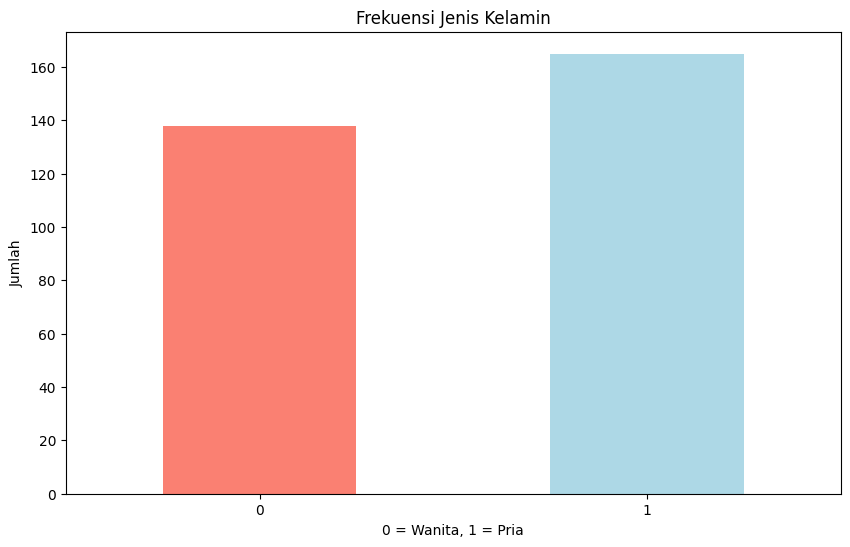

In [10]:
df["target"].value_counts().sort_values(ascending=True).plot(kind="bar", figsize=(10, 6), color=["salmon", "lightblue"]);

plt.title("Frekuensi Jenis Kelamin")
plt.xlabel("0 = Wanita, 1 = Pria")
plt.ylabel("Jumlah")
plt.xticks(rotation=0);


In [11]:
# melihat informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [12]:
# melihat data yang hilang
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [13]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## Frekuensi Penyakit Jantung dengan Jenis Kelamin

In [14]:
df.sex.value_counts()

sex
1    207
0     96
Name: count, dtype: int64

In [15]:
# bandingkan kolom target dengan sex
pd.crosstab(df.target, df.sex)

sex,0,1
target,,
0,24,114
1,72,93


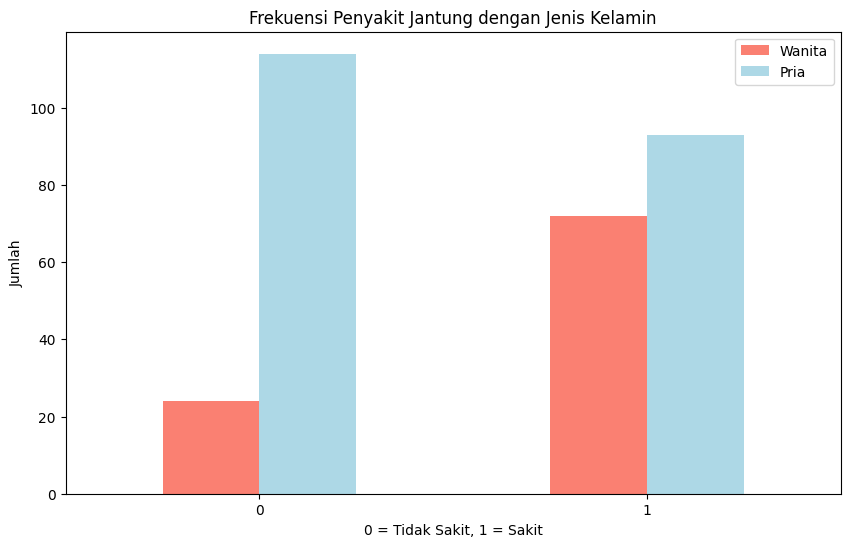

In [16]:
# membuat plot crosstab
pd.crosstab(df.target, df.sex).plot(kind="bar",
                                    figsize=(10, 6),
                                    color=["salmon", "lightblue"]);

plt.title("Frekuensi Penyakit Jantung dengan Jenis Kelamin");
plt.xlabel("0 = Tidak Sakit, 1 = Sakit");
plt.ylabel("Jumlah");
plt.legend(["Wanita", "Pria"]);
plt.xticks(rotation=0);

Karena ada 96 pasien wanita dan 72 diantaranya memiliki nilai positif penyakit jantung, jika pasiennya adalah seorang wanita, ada kemungkinan 75% dia menderita penyakit jantung.

Sedangkan untuk pasien pria, ada 207 hampir setengahnya 45% kemungkinan menunjukkan adanya penyakit jantung.

Jadi dapat disimpulkan berdasarkan grafik di atas, kemungkinan seseorang terkena penyakit jantung adalah 59%.

## Usia dan Denyut Jantung Maksimal

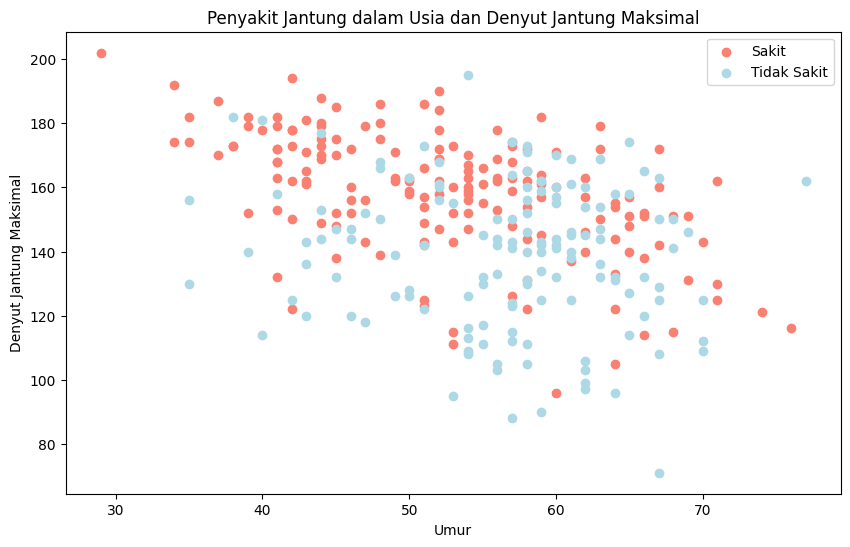

In [17]:
plt.figure(figsize=(10, 6))

# scatter
plt.scatter(df.age[df.target==1],
            df.thalach[df.target==1],
            c="salmon")

plt.scatter(df.age[df.target==0],
            df.thalach[df.target==0],
            c="lightblue")

plt.title("Penyakit Jantung dalam Usia dan Denyut Jantung Maksimal")
plt.xlabel("Umur")
plt.ylabel("Denyut Jantung Maksimal")
plt.legend(["Sakit", "Tidak Sakit"]);

Pada scatter plot diatas tampak semakin muda seseorang, semakin tinggi detak jantung maksimum mereka.

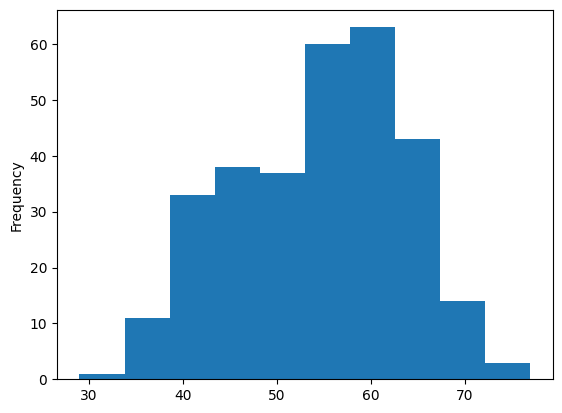

In [18]:
# cek distribusi kolom umur
df.age.plot.hist();

Ini adalah distribusi normal tetapi sedikit bergeser kekanan.

## Frekuensi Penyakit Jantung per Jenis Nyeri Dada

Mencoba variabel lain, kali ini nyeri dada (cp)

In [19]:
pd.crosstab(df.cp, df.target)

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


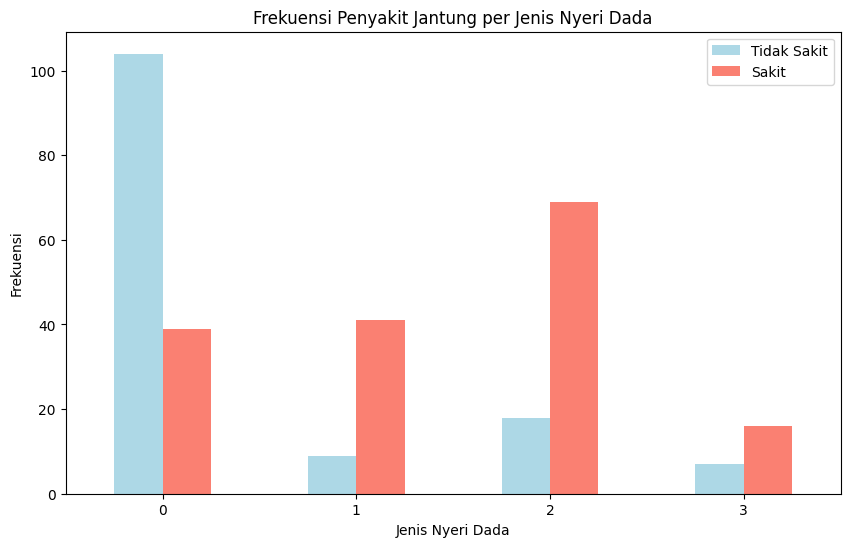

In [20]:
pd.crosstab(df.cp, df.target).plot(kind="bar",
                                   figsize=(10, 6),
                                   color=["lightblue", "salmon"])

plt.title("Frekuensi Penyakit Jantung per Jenis Nyeri Dada")
plt.xlabel("Jenis Nyeri Dada")
plt.ylabel("Frekuensi")
plt.legend(["Tidak Sakit", "Sakit"])
plt.xticks(rotation=0);

**Kamus data**

- cp - chest pain type
    * 0: Typical angina: nyeri dada terkait mengurangi suplai darah ke jantung
    * 1: Atypical angina: nyeri dada tidak berhubungan dengan jantung
    * 2: Non-anginal pain: biasanya kejang esofagus (tidak berhubungan dengan jantung)
    * 3: Asymptomatic: nyeri dada tidak menunjukkan tanda-tanda penyakit

Bagian yang menarik disini, Atypical Angina(1) menyatakan itu tidak berhubungan dengan jantung tetapi tampaknya memiliki rasio yang lebih tinggi daripada Typical Angina(0) yang berhubungan dengan jantung.

Jadi apa itu Atypical Angina?
Pada kasus seperti ini penting untuk diingat, apabila kamus data tidak memberi informasi yang cukup, kita perlu melakukan penelitian lebih lanjut tentang ini. Kita bisa bertanya kepada ahlinya, tetapi karena ini hanya proyek latihan, saya mencoba memahaminya dengan mencari di Google.

## Korelasi antara Variabel Bebas

Tabel korelasi memberikan gambaran tentang variabel mana yang mungkin atau tidak berdampak pada variabel target.

In [21]:
corr_matrix = df.corr()
corr_matrix

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


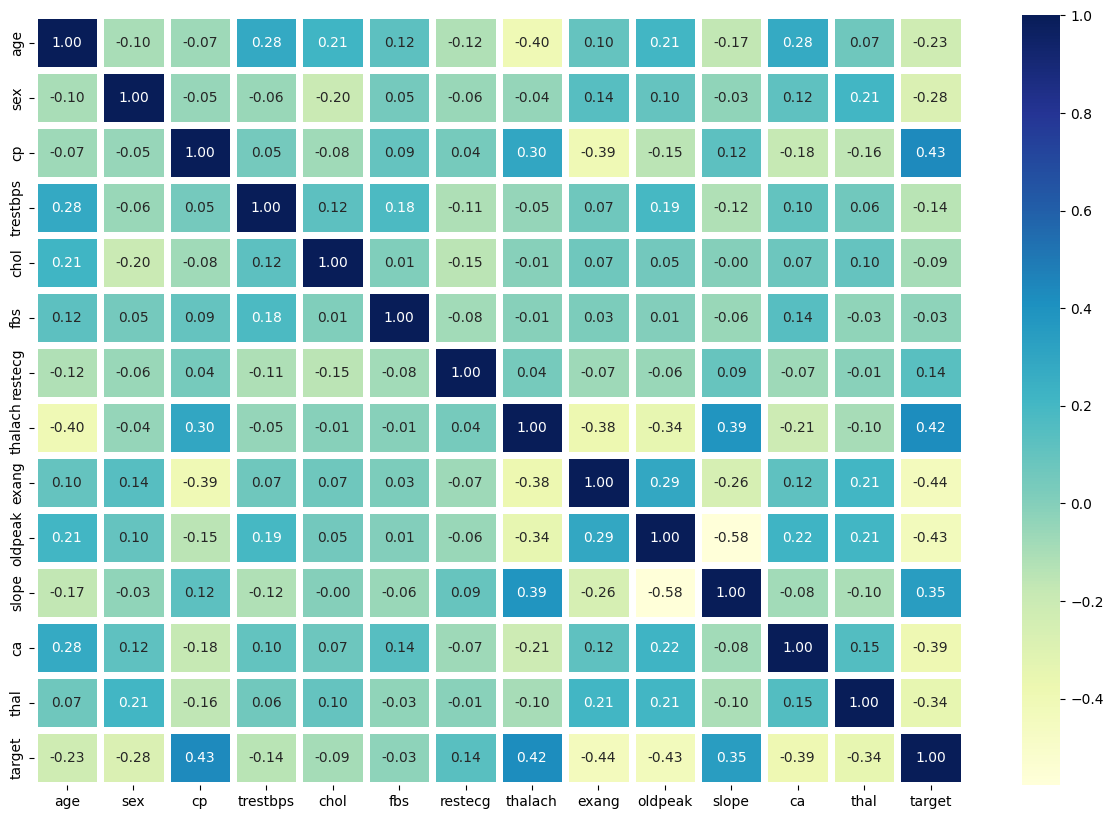

In [22]:
corr_matrix = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix,
            annot=True,
            linewidth=5,
            fmt=".2f",
            cmap="YlGnBu");

Koefisien korelasi bernilai negatif, berarti hubungan antara kedua variabel tersebut negatif atau saling berbanding terbalik. Koefisien korelasi bernilai positif, berarti hubungan antara kedua variabel tersebut positif atau saling berbanding lurus.

## Pemodelan

In [23]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [24]:
# Variabel bebas
X = df.drop("target", axis=1)
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [25]:
# Variabel terikat
y = df.target.values
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Split Data

In [26]:
np.random.seed(8)

Fungsi seed digunakan untuk menyimpan status fungsi random, sehingga dapat menghasilkan angka acak yang sama pada beberapa eksekusi kode pada mesin yang sama atau pada mesin yang berbeda (untuk nilai seed tertentu). Nilai seed adalah angka nilai sebelumnya yang dihasilkan oleh generator. Untuk pertama kalinya ketika tidak ada nilai sebelumnya, ia menggunakan waktu sistem saat ini.

In [27]:
for i in range(5):
    np.random.seed(8)
    print(np.random.randint(1, 1000))

452
452
452
452
452


In [28]:
## Split data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [29]:
X_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
202,58,1,0,150,270,0,0,111,1,0.8,2,0,3
111,57,1,2,150,126,1,1,173,0,0.2,2,1,3
37,54,1,2,150,232,0,0,165,0,1.6,2,0,3
137,62,1,1,128,208,1,0,140,0,0.0,2,0,2
231,57,1,0,165,289,1,0,124,0,1.0,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,67,0,2,115,564,0,0,160,0,1.6,1,0,3
48,53,0,2,128,216,0,0,115,0,0.0,2,0,0
191,58,1,0,128,216,0,0,131,1,2.2,1,3,3
136,60,0,2,120,178,1,1,96,0,0.0,2,0,2


In [30]:
X_test

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
141,43,1,0,115,303,0,1,181,0,1.2,1,0,2
222,65,1,3,138,282,1,0,174,0,1.4,1,1,2
135,49,0,0,130,269,0,1,163,0,0.0,2,0,2
139,64,1,0,128,263,0,1,105,1,0.2,1,1,3
175,40,1,0,110,167,0,0,114,1,2.0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,62,0,0,140,394,0,0,157,0,1.2,1,0,2
151,71,0,0,112,149,0,1,125,0,1.6,1,0,2
262,53,1,0,123,282,0,1,95,1,2.0,1,2,3
110,64,0,0,180,325,0,1,154,1,0.0,2,0,2


In [31]:
y_train, len(y_train)

(array([0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]),
 242)

In [32]:
y_test, len(y_test)

(array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]),
 61)

## Membandingkan Model Machine Learning

- Logistic Regression
- K-Nearest Neighbors
- Random Forest

In [33]:
models = {
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier()
}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Menyesuaikan dan mengevaluasi model machine learning.
    models: dictionary dari model pembelajaran mesin Scikit-Learn yang berbeda.
    X_train: training data
    X_test: testing data
    y_train: label yang terkait dengan data pelatihan
    y_test: label yang terkait dengan data testing
    """
    np.random.seed(8)
    # Membuat dictionary untuk menyimpan skor model
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

## Menggunakan Parameter Default

In [34]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'KNN': 0.6885245901639344,
 'Logistic Regression': 0.8688524590163934,
 'Random Forest': 0.8524590163934426}

## Perbandingan Model

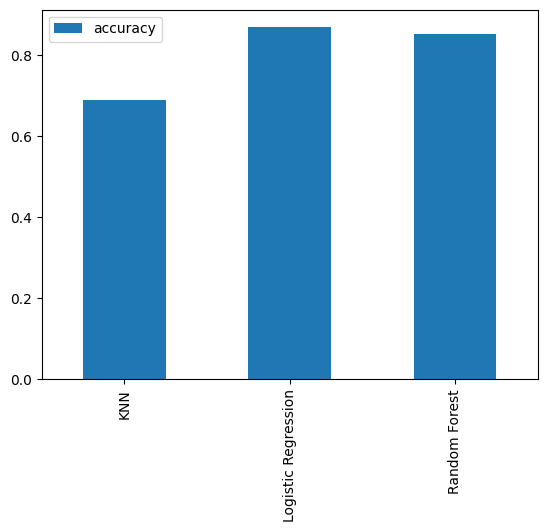

In [35]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar();

## Menggunakan Hyperparameter Tuning dan Cross Validation

### Tune Parameter KNN

Dengan mencoba beberapa nilai n_neighbors yang berbeda.

In [36]:
# List train scores
train_scores = []

# List test scores
test_scores = []

# Mencoba beberapa nilai n
neighbors = range(1,21)

# algoritma
knn = KNeighborsClassifier()

# Loop
for i in neighbors:
    knn.set_params(n_neighbors = i)
    knn.fit(X_train, y_train)

    # Update scores
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

In [37]:
train_scores

[1.0,
 0.8057851239669421,
 0.7933884297520661,
 0.768595041322314,
 0.7644628099173554,
 0.7479338842975206,
 0.731404958677686,
 0.7148760330578512,
 0.7107438016528925,
 0.6859504132231405,
 0.6942148760330579,
 0.6735537190082644,
 0.6942148760330579,
 0.6735537190082644,
 0.6694214876033058,
 0.6570247933884298,
 0.6652892561983471,
 0.6611570247933884,
 0.6528925619834711,
 0.6611570247933884]

In [38]:
test_scores

[0.639344262295082,
 0.4426229508196721,
 0.6229508196721312,
 0.6229508196721312,
 0.6885245901639344,
 0.6885245901639344,
 0.6557377049180327,
 0.6721311475409836,
 0.6557377049180327,
 0.639344262295082,
 0.6557377049180327,
 0.6721311475409836,
 0.6557377049180327,
 0.6885245901639344,
 0.639344262295082,
 0.6721311475409836,
 0.6557377049180327,
 0.6557377049180327,
 0.639344262295082,
 0.6557377049180327]

Nilai KNN tertinggi pada data test: 68.85%


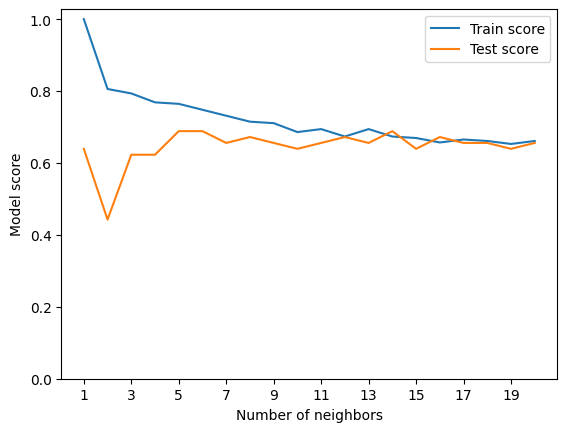

In [39]:
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1, 21, 2))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.ylim(ymin=0)
plt.legend()

print(f"Nilai KNN tertinggi pada data test: {max(test_scores)*100:.2f}%")

## RandomizedSearch()

In [40]:
# Logistic Regression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [41]:
np.random.seed(8)

#LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

rs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [42]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': np.float64(1.623776739188721)}

In [43]:
rs_log_reg.score(X_test, y_test)

0.8688524590163934

Setelah menggunakan RandomizedSearchCV() model Logistic Regression masih memiliki akurasi yang sama ketika menggunakan parameter default.

In [44]:
np.random.seed(8)

#RandomForestClassifier
rs_rfc = RandomizedSearchCV(RandomForestClassifier(),
                            param_distributions=rf_grid,
                            cv=5,
                            n_iter=20,
                            verbose=True)

rs_rfc.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [45]:
rs_rfc.best_params_

{'n_estimators': np.int64(810),
 'min_samples_split': np.int64(12),
 'min_samples_leaf': np.int64(3),
 'max_depth': 3}

In [46]:
rs_rfc.score(X_test, y_test)

0.9016393442622951

Sedangkan model RandomForestClassifier akurasinya meningkat dari 85% menjadi 90%

## GridSearchCV()

In [47]:
np.random.seed(8)

#LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                                param_grid=log_reg_grid,
                                cv=5,
                                verbose=True)

gs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [48]:
gs_log_reg.best_params_

{'C': np.float64(1.623776739188721), 'solver': 'liblinear'}

In [49]:
gs_log_reg.score(X_test, y_test)

0.8688524590163934

Dalam hal ini, saya mendapatkan hasil yang sama seperti sebelumnya karena grid saya hanya memiliki maksimal 20 kombinasi hyperparameter yang berbeda.

**Note**: Saya tidak menggunakan Grid pada RandomForestClassifier karena akan memiliki banyak kombinasi yang berbeda dan membutuhkan waktu yang lama, karena ini hanya latihan dan menyingkat waktu saya menggunakan RandomizedSearchCV.

## Evaluation Model Klasifikasi

In [50]:
y_preds = gs_log_reg.predict(X_test)
y_preds

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1])

In [51]:
y_test

array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])

## ROC dan AUC Scores

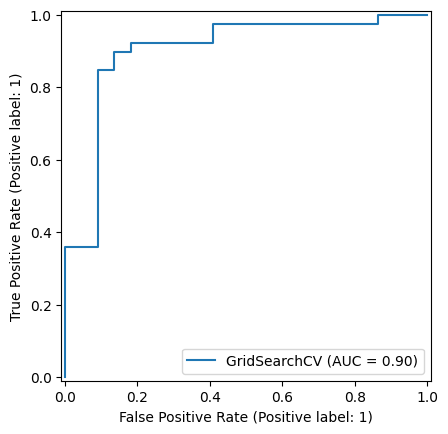

In [53]:
RocCurveDisplay.from_estimator(gs_log_reg, X_test, y_test);

## Confusion Matrix

In [54]:
print(confusion_matrix(y_test, y_preds))

[[20  2]
 [ 6 33]]


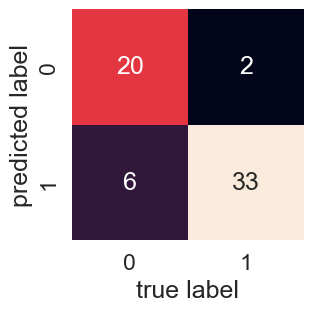

In [55]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")

plot_conf_mat(y_test, y_preds)

## Classification Report

In [56]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.77      0.91      0.83        22
           1       0.94      0.85      0.89        39

    accuracy                           0.87        61
   macro avg       0.86      0.88      0.86        61
weighted avg       0.88      0.87      0.87        61



In [57]:
gs_log_reg.best_params_

{'C': np.float64(1.623776739188721), 'solver': 'liblinear'}

In [58]:
clf = LogisticRegression(C=1.623776739188721,
                         solver="liblinear")

In [59]:
# Accuracy score
cv_acc = cross_val_score(clf,
                         X,
                         y,
                         cv=5, # 5-fold cross-validation
                         scoring="accuracy") # accuracy as scoring
cv_acc

array([0.81967213, 0.86885246, 0.85245902, 0.85      , 0.71666667])

In [60]:
cv_acc = np.mean(cv_acc)
cv_acc

np.float64(0.8215300546448088)

In [61]:
# Precision score
cv_precision = np.mean(cross_val_score(clf,
                                       X,
                                       y,
                                       cv=5, # 5-fold cross-validation
                                       scoring="precision")) # precision as scoring
cv_precision

np.float64(0.817900063251107)

In [62]:
# Recall score
cv_recall = np.mean(cross_val_score(clf,
                                    X,
                                    y,
                                    cv=5, # 5-fold cross-validation
                                    scoring="recall")) # recall as scoring
cv_recall

np.float64(0.8727272727272727)

In [63]:
# F1 score
cv_f1 = np.mean(cross_val_score(clf,
                                X,
                                y,
                                cv=5, # 5-fold cross-validation
                                scoring="f1")) # f1 as scoring
cv_f1

np.float64(0.8431741323998502)

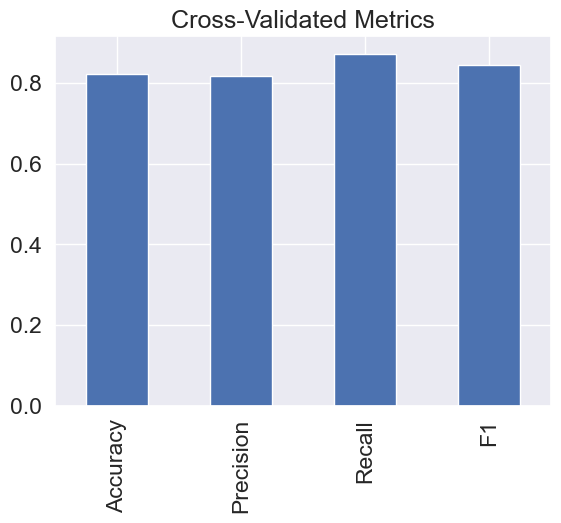

In [64]:
# Visualizing
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                            "Precision": cv_precision,
                            "Recall": cv_recall,
                            "F1": cv_f1},
                            index=[0])
cv_metrics.T.plot.bar(title="Cross-Validated Metrics", legend=False);